In [1]:
import math

from IPython.display import display
import json
import pandas as pd
import os
from pathlib import Path

dirname = os.path.dirname(os.getcwd())
cluster_folders = ["GpResults\\CANMOVERESULTS"]
cluster_folders = [os.path.join(dirname, folder) for folder in cluster_folders]

num_battles = 10
pop_size = 10
total_battles = num_battles * (pop_size - 1)

In [2]:
def get_df(file):
    with open(file) as f:
        results = json.load(f)
        return pd.json_normalize(results)

In [3]:
def get_gp_result_files():
    for folder in cluster_folders:
        return [str(f) for f in Path(folder).rglob('gpResults*.json')]


In [4]:
def seperate_by_generation_across_all_runs(dfs):
    num_generations = len(dfs[0].generations[0])
    for i in range(len(dfs)):
        df = dfs[i]
        df_gens = len(df.generations[0])
        if df_gens != num_generations:
            raise Exception(f"Number of generations for df {i} is {df_gens}, not {num_generations}!")

    fitnesses_across_all_generations_and_runs = []

    for i in range(num_generations):
        #fitnessesForGeneration = []
        ith_generation_per_run = [(pd.DataFrame(df.generations[0])).iloc[i] for df in dfs]
        merged = []
        for gen in ith_generation_per_run:
            pop = pd.DataFrame(gen.population) # TODO why zeroth index?
            fitnesses = [ind['lexicographicFitness'] for ind in pop.fitness]
            merged.extend(fitnesses)
            #print(ind)
        fitnesses_across_all_generations_and_runs.append(pd.DataFrame(merged))
    return fitnesses_across_all_generations_and_runs

In [5]:
def runs_with_number_in_dim(dfs, n, dim):
    included_runs = []
    for df in dfs:
        for fitnesses in get_fitnesses_per_gen(df):
            any_equal_num_in_dim = any([math.isclose(int(f[dim]), int(n)) for f in fitnesses])
            if any_equal_num_in_dim:
                included_runs.append(df)

    return included_runs

In [6]:
def get_fitnesses_per_gen(df):
    for pop in pd.DataFrame(df.generations[0]).population:
        pop = pd.DataFrame(pop)
        fitnesses = [ind['lexicographicFitness'] for ind in pop.fitness]
        yield fitnesses

def get_fitnesses_across_all_runs_flat(dfs):
    all_fitnesses = []
    for df in dfs:
        for pop in pd.DataFrame(df.generations[0]).population:
            pop = pd.DataFrame(pop)
            fitnesses = [ind['lexicographicFitness'] for ind in pop.fitness]
            all_fitnesses.extend(fitnesses)
    return all_fitnesses

In [7]:
def get_data_normalized(dfs):
    f_data = []
    for df in dfs:
        gens = []
        for gen in pd.DataFrame(df.generations[0]).population:
            pop = []
            # display(pd.DataFrame(gen))
            for ind in pd.DataFrame(gen).fitness:
                ind = ind['lexicographicFitness']
                ind[2] *= total_battles
                ind[4] *= total_battles
                ind[2] /= ind[0]
                ind[4] /= total_battles - ind[0]
                pop.append(ind)
            gens.append(pop)
        f_data.append(gens)
    return f_data

In [8]:
files = get_gp_result_files()
data = [get_df(f) for f in files]
print(len(files))
by_generation_merged = seperate_by_generation_across_all_runs(data)

8


In [9]:

def separate_by_generation_and_dimension(fitness_by_generation_merged):
    by_dimension_and_generations = []
    dim_v = fitness_by_generation_merged[0].shape[1] # get the dimension of the fitness vector (5 in our case)
    print(dim_v)
    for dim in range(dim_v):
        single_dimension_for_all_generations = []  # get a list of all values for each dimension across each generation
        for gen in fitness_by_generation_merged:  # loop through each generation and look at each fitness vector
            dim_values = gen.loc[:, dim]  # get the values at the current dimension for each individual in the generation we are looking at
            num_victories = gen.loc[:, 0]  # get the number of victories for each individual in this generation
            if dim == 2:  # if the dimension is Turns To Win
                dim_values = dim_values * total_battles / num_victories
            elif dim == 4:  # if the dimension is Turn To Lose
                num_losses = num_victories.apply(lambda x: total_battles - x) # take the number of victories for each individual and subtract that from the total number of battles
                dim_values = dim_values * total_battles / num_losses

            single_dimension_for_all_generations.append(dim_values)
        df = pd.DataFrame(single_dimension_for_all_generations)
        df.index = list(range(len(fitness_by_generation_merged)))
        by_dimension_and_generations.append(df)
    return by_dimension_and_generations


In [10]:
seperated = separate_by_generation_and_dimension(by_generation_merged)

5


In [11]:
seperated[2].T.min()

0     484.204082
1     484.204082
2     484.204082
3     457.600000
4     484.204082
5     484.204082
6     484.204082
7     484.204082
8     484.204082
9     484.204082
10    484.204082
11    484.204082
12    484.204082
13    484.204082
14    484.204082
15    441.875000
16    484.204082
17    484.204082
18    484.204082
19    484.204082
20    484.204082
dtype: float64

In [12]:
for i in range(len(seperated)):
    display(seperated[i].T.mean())

0     44.7250
1     52.6875
2     51.9375
3     52.8500
4     52.4750
5     52.6125
6     52.3625
7     51.9500
8     52.6375
9     52.6875
10    52.9750
11    52.5750
12    52.0875
13    52.4500
14    53.0000
15    52.3875
16    51.9750
17    52.7125
18    52.0625
19    52.7125
20    52.5875
dtype: float64

0     0.1500
1     0.0375
2     0.0250
3     0.0375
4     0.0125
5     0.0125
6     0.0000
7     0.0125
8     0.0125
9     0.0000
10    0.0125
11    0.0000
12    0.0250
13    0.0125
14    0.0000
15    0.0125
16    0.0000
17    0.0375
18    0.0000
19    0.0125
20    0.0125
dtype: float64

0     544.925046
1     553.653272
2     562.040613
3     547.434225
4     560.280506
5     560.782372
6     555.629263
7     561.576168
8     559.170632
9     551.514221
10    558.351754
11    555.840647
12    558.581290
13    556.067610
14    557.152556
15    548.014485
16    556.738604
17    559.491990
18    559.266496
19    553.731542
20    555.364981
dtype: float64

0     0.1375
1     0.2250
2     0.1750
3     0.1750
4     0.1375
5     0.1625
6     0.1875
7     0.1125
8     0.1500
9     0.1625
10    0.1625
11    0.1500
12    0.1625
13    0.2000
14    0.1875
15    0.2000
16    0.1250
17    0.1500
18    0.1125
19    0.1750
20    0.1625
dtype: float64

0     545.692451
1     571.008298
2     570.217744
3     564.552640
4     570.416537
5     565.114832
6     570.202164
7     566.364606
8     568.352532
9     558.387085
10    571.370140
11    564.571194
12    562.689632
13    569.454395
14    568.026630
15    567.329584
16    561.504951
17    567.117664
18    565.086179
19    564.031690
20    563.516782
dtype: float64

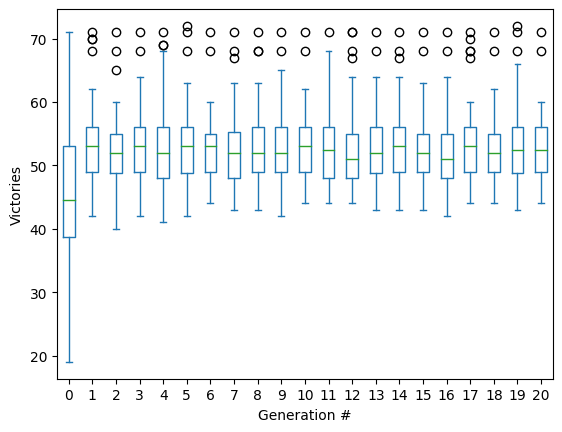

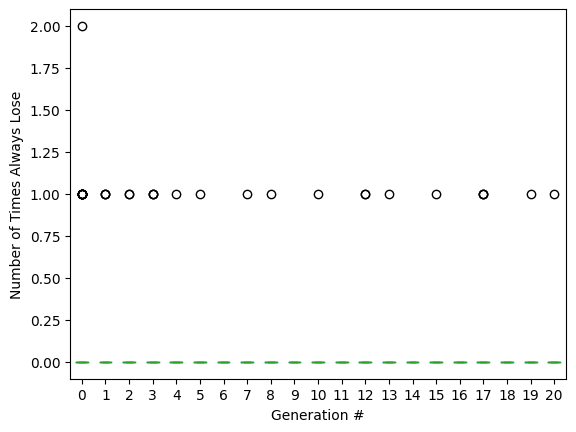

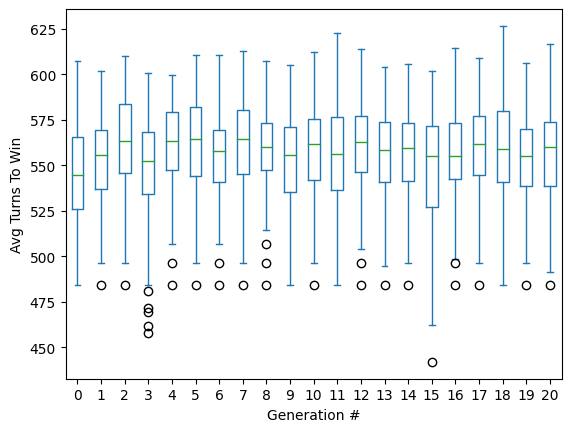

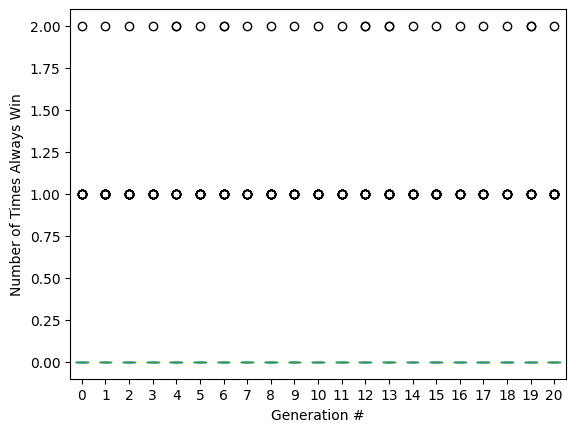

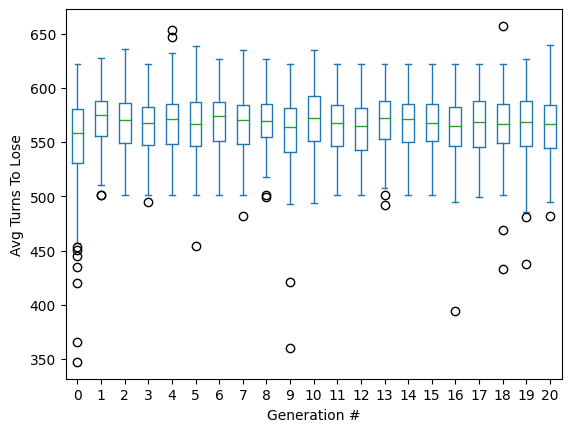

In [13]:
# box whisker seperated by generation and dimension
y_axes = ["Victories", "Number of Times Always Lose", "Avg Turns To Win", "Number of Times Always Win", "Avg Turns To Lose"]
for d in range(len(seperated)):
    ax = seperated[d].T.plot.box()
    ax.set_xlabel("Generation #")
    ax.set_ylabel(y_axes[d])

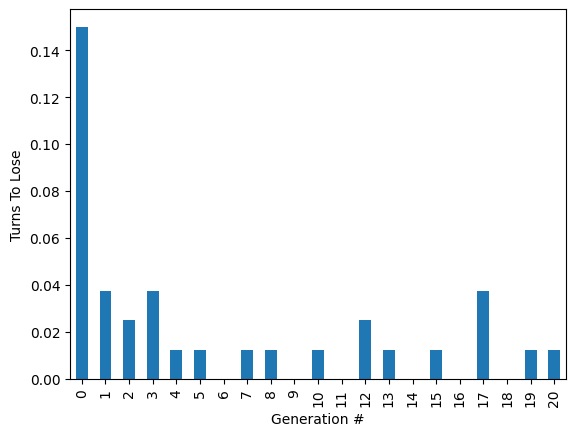

In [14]:
# box whisker seperated by generation and dimension
y_axes = ["Victories", "Number of Times Always Lose", "Turns To Win", "Number of Times Always Win", "Turns To Lose"]
for d in range(len(seperated)):
    ax = seperated[1].T.mean().plot.bar()
    ax.set_xlabel("Generation #")
    ax.set_ylabel(y_axes[d])